In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline


Извлечем данные из директория

In [2]:
ROOT_DIR = '/kaggle/input/image-minor-2022'

In [3]:
DATA_PATH_TEST = os.path.join(ROOT_DIR , 'img_kagl_test')
DATA_PATH_TRAIN = os.path.join(ROOT_DIR ,'img_kagl_train')
TEST_PATH = os.path.join(DATA_PATH_TEST,'test' )
TRAIN_PATH = os.path.join(DATA_PATH_TRAIN,'img_kagl_train')

Всего 4 класса классификации:

In [4]:
os.listdir(TRAIN_PATH)

['1_Table', '2_Armchair', '4_Chair', '3_Sofa']

Посмотрим на некоторых представителей из 'TRAIN_PATH'

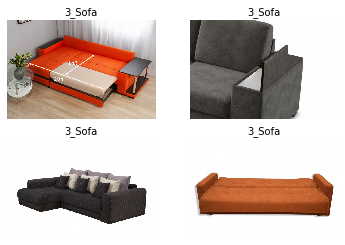

In [5]:
rand = np.random.randint(len(os.listdir(TRAIN_PATH)))
meb_title = os.listdir(TRAIN_PATH)[rand]

meb_path = os.path.join(TRAIN_PATH,meb_title)
meb_images  = os.listdir(meb_path)

n_rows = 2
n_cols = 2

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows,n_cols,index+1)
        sample_image_path = os.path.join(meb_path + '/',meb_images[index])
        meb = imread(sample_image_path)
        plt.imshow(meb,cmap='binary',interpolation='nearest')
        plt.axis('off')
        plt.title(meb_title,fontsize=10)  

In [6]:
num_images = 0
for folder in os.listdir(TRAIN_PATH):
    num_images = num_images + len(os.listdir(os.path.join(TRAIN_PATH + '/' + folder)))    
print ('Число картинок в train dir = {}'.format(num_images))

Число картинок в train dir = 2138


In [7]:
dim1 = []
dim2 = []

for folder in os.listdir(TRAIN_PATH):
    for im_name in os.listdir(TRAIN_PATH + '/' + folder):
        img = imread(os.path.join(TRAIN_PATH,folder,im_name))
        d1,d2 = img.shape[0],img.shape[1]
        dim1.append(d1)
        dim2.append(d2)
print (np.mean(dim1),np.mean(dim2))

444.0 666.0


Все картинки из mg_kagl_train -- (444, 666, 3)

In [8]:
IMAGE_SHAPE = (int(np.mean(dim1)),int(np.mean(dim2)),3)
print(IMAGE_SHAPE)

(444, 666, 3)


Сборка тестовой модели

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)


In [10]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=128,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(units=64,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(units=32,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))

model.add(Dense(units=4,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


2022-12-20 20:49:53.370778: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 444, 666, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 222, 333, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 333, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 166, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 166, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 83, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 584320)            0

In [12]:
BATCH_SIZE = 16
IMAGE_SHAPE[:2]

#Аугментация
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10, 
                               height_shift_range=0.10,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               vertical_flip=False,
                               validation_split=0.3)

In [13]:
image_gen.flow_from_directory(TRAIN_PATH)

Found 2138 images belonging to 4 classes.


In [14]:
train_image_gen = image_gen.flow_from_directory(TRAIN_PATH,target_size=IMAGE_SHAPE[:2],
                                               color_mode='rgb',batch_size=BATCH_SIZE,
                                               class_mode='categorical',seed=1,subset='training')
#нумерация классов
train_image_gen.class_indices

Found 1499 images belonging to 4 classes.


{'1_Table': 0, '2_Armchair': 1, '3_Sofa': 2, '4_Chair': 3}

In [15]:
validation_image_gen = image_gen.flow_from_directory(TRAIN_PATH,target_size=IMAGE_SHAPE[:2],
                                               color_mode='rgb',batch_size=BATCH_SIZE,
                                               class_mode='categorical', shuffle=False,subset='validation',
                                               seed=1)

Found 639 images belonging to 4 classes.


Обучение модели:

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [17]:
history=model.fit(train_image_gen,
                  validation_data = validation_image_gen,
                  callbacks=[early_stop],
                  epochs = 20)

2022-12-20 20:49:56.822627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
94/94 [==============================] - 524s 6s/step - loss: 1.8655 - accuracy: 0.4016 - val_loss: 1.2186 - val_accuracy: 0.4491
Epoch 2/20
94/94 [==============================] - 528s 6s/step - loss: 1.2241 - accuracy: 0.4543 - val_loss: 1.0982 - val_accuracy: 0.5352
Epoch 3/20
94/94 [==============================] - 527s 6s/step - loss: 1.0887 - accuracy: 0.5390 - val_loss: 0.9460 - val_accuracy: 0.6322
Epoch 4/20
94/94 [==============================] - 538s 6s/step - loss: 1.0261 - accuracy: 0.5937 - val_loss: 0.9185 - val_accuracy: 0.6150
Epoch 5/20
94/94 [==============================] - 527s 6s/step - loss: 0.9448 - accuracy: 0.6258 - val_loss: 0.8697 - val_accuracy: 0.6823
Epoch 6/20
94/94 [==============================] - 528s 6s/step - loss: 0.9633 - accuracy: 0.5951 - val_loss: 0.9300 - val_accuracy: 0.6213
Epoch 7/20
94/94 [==============================] - 527s 6s/step - loss: 0.9473 - accuracy: 0.6211 - val_loss: 0.9858 - val_accuracy: 0.5775
Epoch 8/20
94

Text(0, 0.5, 'loss')

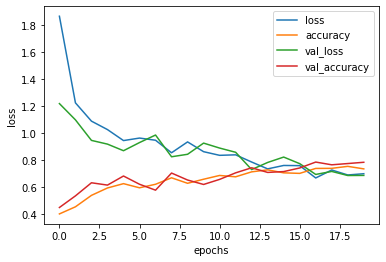

In [18]:
#график 
df_losst = pd.DataFrame(model.history.history)
df_losst.head()

df_losst[['loss','accuracy','val_loss','val_accuracy']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')

In [19]:
model.evaluate(validation_image_gen)

40/40 [==============================] - 78s 2s/step - loss: 0.6512 - accuracy: 0.7793


[0.6512079834938049, 0.7793427109718323]

In [20]:
test_image_gen = ImageDataGenerator(rescale=1./255)   

Вытащим отдельно тестовые файлы

In [21]:
os.makedirs('/kaggle/test',exist_ok=True)
from distutils.dir_util import copy_tree
TEST_PATH

'/kaggle/input/image-minor-2022/img_kagl_test/test'

In [22]:
test_dir = TEST_PATH
direct = '/kaggle/test/test'

copy_tree(test_dir,direct)

test_path = '/kaggle/test'

test_generator = test_image_gen.flow_from_directory(directory=test_path,
                                                 target_size=IMAGE_SHAPE[:2],
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=None,
                                                  shuffle=False)

Found 1613 images belonging to 1 classes.


Проверим модель на тестовом наборе:

In [23]:
pred = model.predict(test_generator,steps=len(test_generator),verbose=1)

101/101 [==============================] - 92s 906ms/step


Соберем csv файл, формат в примере:

Image, Type

2.jpg, 1

э7.jpg, 2

12.jpg, 3

etc.

Классификация соответственно 1 - Table, 2 - Armchair, 3 - Sofa, 4 - Chair 

In [24]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_image_gen.class_indices)
labels = dict((i,k) for k,i in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [25]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,test/0.jpg,3_Sofa
1,test/1.jpg,1_Table
2,test/100.jpg,4_Chair
3,test/1001.jpg,4_Chair
4,test/1002.jpg,3_Sofa
...,...,...
1608,test/990.jpg,3_Sofa
1609,test/992.jpg,1_Table
1610,test/993.jpg,3_Sofa
1611,test/998.jpg,1_Table


In [26]:
def file_name(st):
    x = st.split('/')
    y = x[1]
    return y

In [27]:
results['Image'] = results['Filename'].apply(file_name)
results.drop('Filename',axis=1,inplace=True)

def pred(st):
    if st=='1_Table':
        return 1
    elif st == '2_Armchair':
        return 2
    elif st == '3_Sofa':
        return 3
    elif st == '4_Chair':
        return 4
    
results['Type'] = results['Predictions'].apply(pred)
results.head(100)

,Predictions,Image,Type
0,3_Sofa,0.jpg,3
1,1_Table,1.jpg,1
2,4_Chair,100.jpg,4
3,4_Chair,1001.jpg,4
4,3_Sofa,1002.jpg,3
...,...,...,...
95,3_Sofa,1158.jpg,3
96,3_Sofa,1159.jpg,3
97,3_Sofa,116.jpg,3
98,3_Sofa,1160.jpg,3


In [28]:
results.drop('Predictions',axis=1,inplace=True)
results.head(10)

,Image,Type
0,0.jpg,3
1,1.jpg,1
2,100.jpg,4
3,1001.jpg,4
4,1002.jpg,3
5,1008.jpg,3
6,1009.jpg,3
7,101.jpg,1
8,1011.jpg,3
9,1013.jpg,3


In [29]:
results.to_csv('submission.csv',index=False)
os.listdir('/kaggle/working')

['__notebook__.ipynb', 'submission.csv']